# Deephyper analytics - single study
**path to data file**: data_2020-06-14_19.json

for customization please see: https://matplotlib.org/api/matplotlib_configuration_api.html

## Setup & Data loading

In [1]:
path_to_data_file = 'data_2020-06-14_19.json'

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
from pprint import pprint
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, Markdown

width = 21
height = width/1.618

matplotlib.rcParams.update({
    'font.size': 21,
    'figure.figsize': (width, height), 
    'figure.facecolor': 'white', 
    'savefig.dpi': 72, 
    'figure.subplot.bottom': 0.125, 
    'figure.edgecolor': 'white',
    'xtick.labelsize': 21,
    'ytick.labelsize': 21})

def to_sec(ts):
    try:
        return datetime.strptime(ts, '%Y-%m-%d %H:%M:%S').timestamp()
    except:
        return datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f').timestamp()

def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

data = load_json(path_to_data_file)
print(list(data.keys()))

start_infos = data['start_infos'][0]

try:
    start_time = to_sec(data['workload']['times'][0])
except:
    start_time = to_sec(start_infos['timestamp'])
    
pprint(start_infos)

['fig', 'raw_rewards', 'arch_seq', 'timestamps', 'start_infos']
{'alg': 'random',
 'encoded_space': '{"create_search_space":{"func":"gnn_test2.qm9.search_space.create_search_space","kwargs":{"num_layers":3}},"hyperparameters":{"verbose":1,"batch_size":32,"learning_rate":0.01,"optimizer":"adam","num_epochs":20,"callbacks":{"EarlyStopping":{"monitor":"val_r2","mode":"max","verbose":0,"patience":5}}},"load_data":{"func":"gnn_test2.qm9.load_data.load_data","kwargs":{}},"loss":"mse","metrics":["r2"],"objective":"val_r2__last","preprocessing":{"func":"deephyper.search.nas.model.preprocessing.minmaxstdscaler"},"seed":2019}',
 'nworkers': 1,
 'timestamp': '2020-06-13 16:38:39'}


## Number of different search_spaces & evaluations done

In [3]:
try:
    from deephyper.search import util
    
    config = json.loads(start_infos['encoded_space'])

    config['create_search_space']['func'] = util.load_attr_from(
        config['create_search_space']['func'])

    cs_kwargs = config['create_search_space'].get('kwargs')
    if cs_kwargs is None:
        create_search_space = lambda: config['create_search_space']['func']()
    else:
        create_search_space = lambda: config['create_search_space']['func'](**cs_kwargs)

    search_space = create_search_space()

    den_archs = list()
    for arch_seq in tqdm(data['arch_seq']):
        res = search_space.denormalize(arch_seq)
        den_archs.append(str(res))

    num_diff_archs = len({e for e in den_archs})
    num_evaluations = len(data['arch_seq'])
    display(Markdown(f'The search has done **{num_evaluations}** *evaluations* and has generated **{num_diff_archs}** *different neural networkss*.'))
    display(Markdown(f'The search space size is **{search_space.size}**\nand **{num_diff_archs/search_space.size*100}**% has been explored.'))
except Exception as e:
    print('Exception: ', e)
    print('Cell failed so it was skipped... it is probably related with a bad kernel being used.')

Using TensorFlow backend.
  0%|          | 0/90 [00:00<?, ?it/s]

Exception:  Wrong sequence given: '[0.8323024001314224, 0.7889290619064494, 0.9385678954207153, 0.16059637997392429, 0.6488539744120456, 0.8325765404421139, 0.9888735139157468, 0.9322143923769549, 0.7933123406870071]' of length 9 when a valid sequence should be of length 3
Cell failed so it was skipped... it is probably related with a bad kernel being used.


## Search trajectory
### Raw rewards

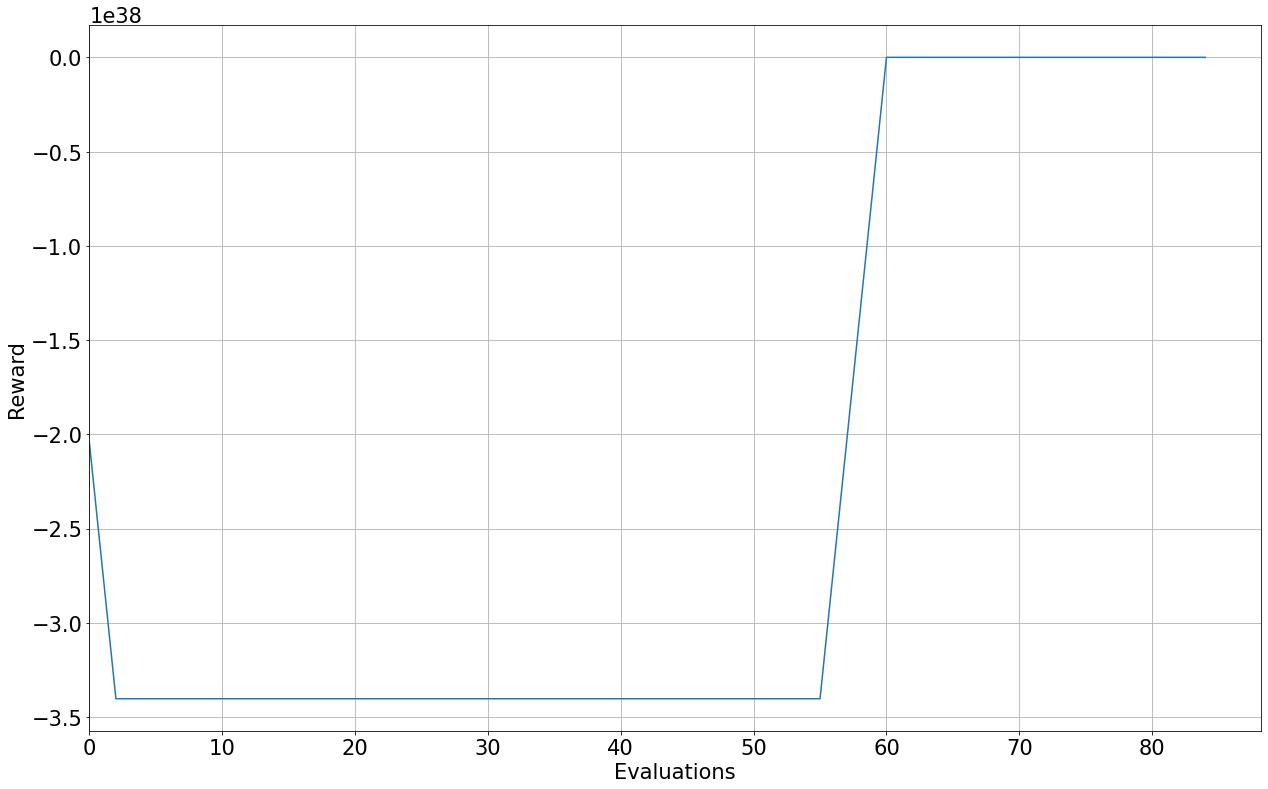

In [4]:
def moving_average(data_list, window_size=100):
    res_list = list()
    for i in range(len(data_list) - window_size):
            res_list.append(sum(data_list[i:i+window_size])/window_size)
    return res_list

window_size = 5

plt.plot(moving_average(data['raw_rewards'], window_size))

plt.ylabel('Reward')
plt.xlabel('Evaluations')
plt.xlim(left=0)
plt.grid()
plt.show()

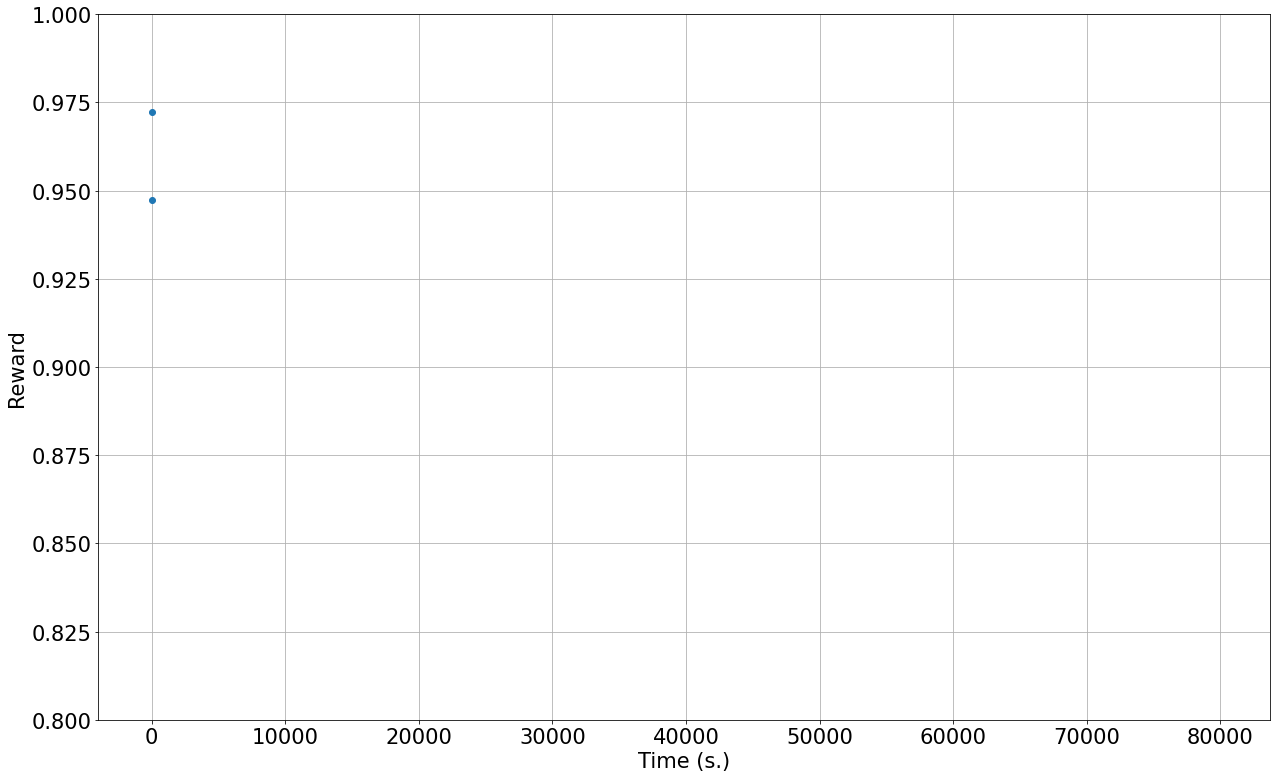

In [6]:
times = [to_sec(ts)-start_time for ts in data['timestamps']]
plt.plot(times, data['raw_rewards'], 'o')

plt.ylabel('Reward')
plt.xlabel('Time (s.)')

plt.xlim(left=0)
plt.ylim(0.8, 1.0)
plt.grid()
plt.show()

### Average reward per batch

In [7]:
avr_reward_mbatches = [np.mean(stats['rewards']) for stats in data['env_stats']]
times = [to_sec(stats['timestamp'])-start_time for stats in data['env_stats']]

plt.plot(times, avr_reward_mbatches)

plt.ylabel('Reward')
plt.xlabel('Time (s.)')
plt.xlim(left=0)
plt.grid()
plt.show()

KeyError: 'env_stats'

## Workload
### Profile

In [8]:
times = [to_sec(t)-start_time for t in data['workload']['times']]
num_running = (np.array(data['workload']['num_running']) - 1)
try:
    nworkers = start_infos['nworkers']
except:
    nworkers = int(input('How many workers do you have ?'))
num_running_norm = num_running / nworkers

plt.fill_between(times, num_running_norm, step="post", label='real')
plt.plot(moving_average(times), moving_average(num_running_norm), 'r:', linewidth=3, label='avrg')

plt.xlabel('Time (s)')
plt.ylabel('Node utilization')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.grid()
plt.show()

KeyError: 'workload'

### Pie chart

In [9]:
def integrate_square(x, y, offset=0):
    res = 0
    for i in range(len(x)-1):
        res += (x[i+1] - x[i]) * y[i]
    return res

nagents = start_infos.get('nagents', 1)
nworkers = start_infos['nworkers'] - nagents
total_available = nworkers * times[-1]
used_time = integrate_square(times, num_running)
unused_time = total_available - used_time
perc_used_time = int(used_time / total_available * 100)
perc_unused_time = int(unused_time / total_available * 100)
label_used_time = f'{perc_used_time}% used'
label_unused_time = f'{perc_unused_time}% unused'
lpie = plt.pie([used_time, unused_time],
               labels=[label_used_time, label_unused_time],
               colors=['green', 'red'])
plt.show()

NameError: name 'num_running' is not defined

## Minibatches
### Timing of minibatches evaluation

In [10]:
nca_list = []
times = []

for stats in tqdm(data['env_stats']):
    nca = stats['batch_computation']
    nca_list.append(nca)
    time = to_sec(stats['timestamp']) - start_time
    times.append(time)
        
display(Markdown(f'**Mean time** of batch computation = _{np.mean(nca_list)}_ *s.*'))
display(Markdown(f'**Median time** of batch computation = _{np.median(nca_list)}_ *s.*'))

plt.scatter(times, nca_list, s=55, facecolors='none', edgecolors='b')
        
plt.ylabel('Batch Computation Time')
plt.xlabel('Time (s.)')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid()
plt.show()

KeyError: 'env_stats'

## Cache
### Number of evaluation cached

In [11]:
window_size = 1

nca_list = []
times = []
last_nca_rank = {}
for stats in tqdm(data['env_stats']):
    if 'ranks' in stats:
        rank = stats['rank']
    else:
        rank = 0
    nca = stats['num_cache_used']
    time = to_sec(stats['timestamp']) - start_time
    last_nca = last_nca_rank.get(rank)
    if last_nca_rank.get(rank) is None:
        last_nca = 0
    nca_list.append(nca-last_nca)
    times.append(time)
    last_nca_rank[rank] = nca

nca_list = moving_average(nca_list, window_size)
times = moving_average(times, window_size)

plt.scatter(times, nca_list, s=55, facecolors='none', edgecolors='b')
        
plt.ylabel('Cache accesses')
plt.xlabel('Time (s.)')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid()
plt.show()

KeyError: 'env_stats'